# 1. Doc2Vec method

## read saved file

In [1]:
pwd

u'/home/zack/Documents/data/reviews/605301'

In [3]:
ls | grep .txt

Book_del_4000_neg.txt
Book_del_4000_pos.txt
ChnSentiCorp_htl_ba_4000_neg.txt
ChnSentiCorp_htl_ba_4000_pos.txt
Dangdang_Book_neg.txt
Dangdang_Book_pos.txt
Jingdong_NB_4000_neg.txt
Jingdong_NB_4000_pos.txt


In [7]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import numpy as np
import gensim

from gensim.models.doc2vec import Doc2Vec,LabeledSentence
from sklearn.cross_validation import train_test_split

%matplotlib inline

def get_dataset(write=True):
    files = os.listdir('.')
    neg_files = [neg for neg in files if neg.endswith("neg.txt")]
    pos_files = [pos for pos in files if pos.endswith("pos.txt")]
    neg_reviews = []
    pos_reviews = []
    for i in neg_files:
        print 'read data from --', i
        with open(i, "r") as f:
            neg_reviews += (line.decode('utf-8') for line in f.readlines())
            
    for j in pos_files:
        print 'read data from --', j
        with open(j, "r") as f:
            pos_reviews += (line.decode('utf-8') for line in f.readlines())
    
    print 'done!!!'
    print 'neg_reviews: ', len(neg_reviews)
    print 'pos_reviews: ', len(pos_reviews)
    #print neg_reviews[0]
    #y = np.concatenate((np.ones(8000), np.zeros(8000)), axis=0)
    #x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2)
    if(write):
        with open('pos_reviews.txt', 'w') as f:
            for line in pos_reviews:
                f.write(line.encode('utf-8') + '\n')
        with open('neg_reviews.txt', 'w') as f:
            for line in neg_reviews:
                f.write(line.encode('utf-8') + '\n')
    
    y = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))
    # 将数据分割为训练与测试集
    x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_reviews, neg_reviews)), y, test_size=0.2)

    # 数据清洗预处理，中文根据需要进行修改
    def cleanText(corpus):
        punctuation = """.,?!:;(){}[]，。！？：“‘（）【】；""".decode('utf-8')
        corpus = [z.replace('\n','') for z in corpus]
        corpus = [z.replace('<br />', ' ') for z in corpus]

        #treat punctuation as individual words
        for c in punctuation:
            corpus = [z.replace(c, ' %s '%c) for z in corpus]
        corpus = [z.split() for z in corpus]
        return corpus

    x_train = cleanText(x_train)
    x_test = cleanText(x_test)
    
    #Gensim的Doc2Vec应用于训练要求每一篇文章/句子有一个唯一标识的label.
    #我们使用Gensim自带的LabeledSentence方法. 标识的格式为"TRAIN_i"和"TEST_i"，其中i为序号
    def labelizeReviews(reviews, label_type):
        labelized = []
        for i,v in enumerate(reviews):
            label = '%s_%s'%(label_type,i)
            labelized.append(LabeledSentence(v, [label]))
        return labelized
    
    print 'labeling documents .......'
    x_train = labelizeReviews(x_train, 'TRAIN')
    x_test = labelizeReviews(x_test, 'TEST')

    return x_train,x_test,y_train, y_test

def build_model(x_train, x_test, save=True):
    if(save):
        big_list = x_train + x_test
        model = Doc2Vec(min_count=2, window=10, size=100, sample=1e-4, negative=5, workers=8)
        model.build_vocab(big_list)
        model.train(big_list)
	print 'saving model to file.....'  
        model.save('./sentim.d2v')
    else:
	print 'loading model from file.....'
	model = Doc2Vec.load('./sentim.d2v')
    return model

def get_vectors(model, x_train, x_test):
    print 'getting vectors .........'
    
    #infer from model
    xtrain = []
    xtest = []
    for doc_id in range(len(x_train)):
        inferred_vector = model.infer_vector(x_train[doc_id].words)
        xtrain.append(inferred_vector)
    for doc_id in range(len(x_test)):
        inferred_vector = model.infer_vector(x_test[doc_id].words)
        xtest.append(inferred_vector)
    return np.array(xtrain), np.array(xtest)
    '''
    train_tags = []
    test_tags = []
    for i in range(len(x_train)):
        train_tags += x_train[i].tags
        
    for i in range(len(x_test)):
        test_tags += x_test[i].tags
        
    x_train = [model.docvecs[tag] for tag in train_tags]
    x_test = [model.docvecs[tag] for tag in test_tags]
    return np.array(x_train), np.array(x_test)
    '''   
    
    
def Classifier(x_train,y_train,x_test, y_test):
    #使用sklearn的Logistic regression分类器
    print 'building classifier ........'
    from sklearn.linear_model import LogisticRegression

    lr = LogisticRegression(penalty='l1')
    lr.fit(x_train, y_train)

    print 'Test Accuracy: %.2f'%lr.score(x_test, y_test)

    return lr

def ROC_curve(lr,y_test):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    pred_probas = lr.predict_proba(x_test)[:,1]

    fpr,tpr,_ = roc_curve(y_test, pred_probas)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.show()

read data from -- Book_del_4000_neg.txt
read data from -- Jingdong_NB_4000_neg.txt
read data from -- Dangdang_Book_neg.txt
read data from -- ChnSentiCorp_htl_ba_4000_neg.txt
read data from -- Dangdang_Book_pos.txt
read data from -- Jingdong_NB_4000_pos.txt
read data from -- ChnSentiCorp_htl_ba_4000_pos.txt
read data from -- Book_del_4000_pos.txt
done!!!
neg_reviews:  8000
pos_reviews:  8000
labeling documents .......
loading model from file.....
getting vectors .........
building classifier ........
Test Accuracy: 0.76


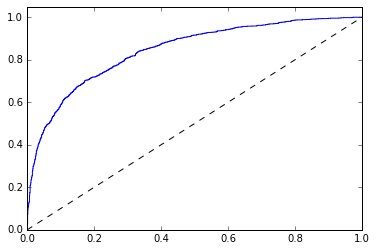

In [8]:
x_train, x_test, y_train, y_test = get_dataset(write=False)
model = build_model(x_train, x_test, save=False)
x_train, x_test = get_vectors(model, x_train, x_test)
lr = Classifier(x_train, y_train, x_test, y_test)
ROC_curve(lr, y_test)

## print relevance documents

In [51]:
train_0 = model.docvecs['TRAIN_0']

In [52]:
model.docvecs.most_similar([train_0], topn=5)

[('TRAIN_0', 1.0),
 ('TRAIN_9322', 0.7864269614219666),
 ('TRAIN_10173', 0.7711612582206726),
 ('TRAIN_785', 0.7481350898742676),
 ('TRAIN_3758', 0.7441282272338867)]

In [60]:
print ''.join(x_train[0].words)
print y_train[0]
print ''.join(x_train[9322].words)
print y_train[9322]
print ''.join(x_train[10173].words)
print y_train[10173]

速度不错，测试魔兽单机，一点都不卡。功能齐全，4K以下我想应该是性价比相当高的了。
1.0
每次读这种书，总是受益良多。我们在熙熙攘攘的社会里奔波，太需要这种书来帮助我们。让我们懂得身体的宝贵，珍惜我们的生命，更为重要的是它教会我们如何去保护修复自己的身体，去更好地生活，去更好地实现自己的人生理想。建议每个人都应该有这类书籍，有空多多读读，让自己活得更加轻松愉快。当你按着书的“旨意”去尝试，你也许会有更多的获得。祝你身体健康！
1.0
酒店的地理位置还算便利，但是酒店的设施非常成旧。前台一听说是携程订的，给的房间全部是陈旧的客房，设施很差，但房价很高。和当地朋友一说，他们认为价格比他们去订高多了！唉……
0.0


In [7]:
# what a document vector look like
model.docvecs[0]

array([-0.01165053, -0.00453387, -0.00948982, -0.01274511, -0.01126811,
       -0.00794393,  0.01506125, -0.00780007, -0.01146256, -0.00082625,
        0.00968573,  0.00338903,  0.0093376 ,  0.00062826, -0.00457715,
       -0.02000429, -0.00543132, -0.01115765,  0.00411171,  0.02659816,
        0.01863506, -0.00063907,  0.00442604,  0.00013319, -0.00059485,
       -0.0215746 , -0.01106862,  0.00161483,  0.01857649,  0.00938686,
        0.02693475, -0.01447992,  0.00027773,  0.0083546 , -0.01329132,
        0.00081952,  0.01176455, -0.0048128 ,  0.01737118, -0.00794488,
        0.00547707,  0.00341952,  0.00387904, -0.00132652,  0.00473905,
        0.00313919,  0.01362127, -0.01570269,  0.01050583, -0.00741356,
       -0.01361246, -0.00708964,  0.01313181, -0.00848943, -0.00292285,
        0.01175815, -0.01380821, -0.01202678,  0.00390187,  0.01166876,
        0.00319697, -0.00486824, -0.00777338,  0.00051209, -0.00201229,
        0.00134599, -0.00251676, -0.00619263, -0.00628006,  0.00

In [9]:
for (word, freq) in model.most_similar(u'垃圾'):
    print word,freq
print '\n'
for (word, freq) in model.most_similar(u'喜欢'):
    print word,freq

没 0.626695275307
说 0.59926956892
后悔 0.578242897987
没有 0.577276229858
差 0.576506972313
. 0.56924444437
就是 0.568525314331
是 0.564729690552
不爽 0.564680933952
！ 0.561031639576


是 0.753024876118
觉得 0.751504063606
看 0.746293842793
， 0.743816256523
好看 0.74192917347
本书 0.736092627048
这 0.733344197273
。 0.730485022068
适合 0.727415621281
的 0.726329982281


# bag of words method for sentiment analysis

In [4]:
import os
import numpy as np
import gensim
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

def read_data(filename):
    data = {}
    files = os.listdir(filename)
    neg_files = [neg for neg in files if neg.endswith("neg.txt")]
    pos_files = [pos for pos in files if pos.endswith("pos.txt")]
    neg_sents = []
    pos_sents = []
    for i in neg_files:       
        with open(i, "r") as f:
            neg_sents += f.readlines()
    for j in pos_files:
        with open(j, "r") as f:
            pos_sents += f.readlines()
    data['neg'] = neg_sents
    data['pos'] = pos_sents
    return data

def remove_stopwords(stopwords_path, data):
    with open(stopwords_path,'r') as file:  
        stop_list = set([line.strip() for line in file])  
    data['neg'] = [[word for word in document.split() if word not in stop_list] for document in data['neg']]
    data['pos'] = [[word for word in document.split() if word not in stop_list] for document in data['pos']]
    return data

def vectorize(data):
    big_data = data['neg'] + data['pos']
    dictionary = gensim.corpora.Dictionary(big_data)
    corpus = [dictionary.doc2bow(text) for text in big_data]
    #matrix = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))
    matrix = gensim.matutils.corpus2csc(corpus)
    return matrix.T

/home/zack/anaconda2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [6]:
def build_model(matrix):
    print "shape of the matrix:  ", matrix.shape
    y = np.concatenate((np.ones(8000), np.zeros(8000)), axis=0)
    x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2)
    print "training set:  ", x_train.shape
    print "test set:  ", x_test.shape
    model = LogisticRegression(penalty='l1')
    model.fit(x_train, y_train)
    print 'Test Accuracy: %.3f'%model.score(x_test, y_test)

In [6]:
data = read_data(".")

print 'number of neg files: ', len(data['neg'])
print 'number of pos files: ', len(data['pos'])
# before removing the stop words
print data['neg'][0]

data1 = remove_stopwords('/home/zack/stop_list_li.txt', data)
# after removing the stop words
print " ".join(data1['neg'][0])

number of neg files:  8000
number of pos files:  8000
没有 想象 的 那么 精彩 实用 很多 观点 比较 片面 ， 感觉 作者 有些 想当然 的 看 问题 了 。

没有 想象 那么 精彩 实用 很多 观点 比较 片面 感觉 作者 有些 想当然 看 问题


In [7]:
data = vectorize(data1)
print 'data matrix shape: ', data.shape

data matrix shape:  (16000, 35258)


In [1]:
# save matrix in disk
import pickle
with open('big_matrix.pickle', 'wb') as f:
    pickle.dump(data, f)
with open('big_matrix.pickle', 'rb') as f:
    matrix = pickle.load(f)

In [10]:
pred = build_model(matrix)

shape of the matrix:   (16000, 35258)
training set:   (12800, 35258)
test set:   (3200, 35258)
Test Accuracy: 0.903


In [11]:
from sklearn.svm import SVC

def build_model_svc(matrix):
    print "shape of the matrix:  ", matrix.shape
    y = np.concatenate((np.ones(8000), np.zeros(8000)), axis=0)
    x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2)
    print "training set:  ", x_train.shape
    print "test set:  ", x_test.shape
    model = SVC(kernel='linear')
    model.fit(x_train, y_train)
    print 'Test Accuracy: %.3f'%model.score(x_test, y_test)

build_model_svc(matrix)

shape of the matrix:   (16000, 35258)
training set:   (12800, 35258)
test set:   (3200, 35258)
Test Accuracy: 0.911


In [12]:
def build_model_svc(matrix):
    print "shape of the matrix:  ", matrix.shape
    y = np.concatenate((np.ones(8000), np.zeros(8000)), axis=0)
    x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2)
    print "training set:  ", x_train.shape
    print "test set:  ", x_test.shape
    model = SVC() # rbf kernel
    model.fit(x_train, y_train)
    print 'Test Accuracy: %.3f'%model.score(x_test, y_test)

build_model_svc(matrix)

shape of the matrix:   (16000, 35258)
training set:   (12800, 35258)
test set:   (3200, 35258)
Test Accuracy: 0.640


In [14]:
from sklearn.svm import LinearSVC
def build_model_linearSvc(matrix):
    print "shape of the matrix:  ", matrix.shape
    y = np.concatenate((np.ones(8000), np.zeros(8000)), axis=0)
    x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2)
    print "training set:  ", x_train.shape
    print "test set:  ", x_test.shape
    model = LinearSVC(penalty='l1',dual=False ) # rbf kernel
    model.fit(x_train, y_train)
    print 'Test Accuracy: %.3f'%model.score(x_test, y_test)

build_model_linearSvc(matrix)

shape of the matrix:   (16000, 35258)
training set:   (12800, 35258)
test set:   (3200, 35258)
Test Accuracy: 0.903


In [15]:
from sklearn.svm import LinearSVC
def build_model_linearSvc(matrix):
    print "shape of the matrix:  ", matrix.shape
    y = np.concatenate((np.ones(8000), np.zeros(8000)), axis=0)
    x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2)
    print "training set:  ", x_train.shape
    print "test set:  ", x_test.shape
    model = LinearSVC() # rbf kernel
    model.fit(x_train, y_train)
    print 'Test Accuracy: %.3f'%model.score(x_test, y_test)

build_model_linearSvc(matrix)

shape of the matrix:   (16000, 35258)
training set:   (12800, 35258)
test set:   (3200, 35258)
Test Accuracy: 0.897
